# Order Profile Analysis
GitHub location: https://github.com/LarsTinnefeld/Olist-order-profile-analysis

**A project of the Olist ecommerce business analysis.**

<img src="https://i2.wp.com/dataneophyte.com/wp-content/uploads/2019/12/Logo-01.png" width="400" height="300">


## Questions to answer
1. What conclusions can we draw from order- and SKU-profile?
2. Impacts of Olist's business model on inventory and fullfillment process
3. Can we predict buying behaviour between articles (association)?

## Table of Contents

I. [Data Import and Wrangling](#data)<br>
II. [Exploratory Date Analysis](#eda)<br>
III. [Order and SKU profile](#profile)<br>
IV. [Affinity Analysis](#tbd)<br>
V. [Evaluation](#evaluation)<br>
VI. [Conclusion](#conclusion)

---
## <a class="anchor" id="data">I. Data Import and Wrangling</a>

### 1. Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from datetime import datetime as dt
%matplotlib inline
sns.set_style("whitegrid")

### 2. Importing order data
Part of the data was inherited from the initial Olist data analysis.

General data structure:

<img src="https://i.imgur.com/HRhd2Y0.png" width="700" height="450">

We will import the already cleanded dataset from the shared dataset of the Olist business analysis.

<img src="https://github.com/LarsTinnefeld/olist_ecom_analysis/blob/main/Olist-Analysis_1_New_tables.PNG?raw=true" width="700" height="400">

In [2]:
# Importing consolidated order data table
df_orders_consolidated = pd.read_csv('https://raw.githubusercontent.com/LarsTinnefeld/olist_ecom_analysis/main/df_orders_consolidated.csv')

In [3]:
# Refresher
df_orders_consolidated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102425 entries, 0 to 102424
Data columns (total 31 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Unnamed: 0                     102425 non-null  int64  
 1   order_id                       102425 non-null  object 
 2   customer_id                    102425 non-null  object 
 3   order_status                   102425 non-null  object 
 4   order_purchase_timestamp       102425 non-null  object 
 5   order_approved_at              102425 non-null  object 
 6   order_delivered_carrier_date   102425 non-null  object 
 7   order_delivered_customer_date  102425 non-null  object 
 8   order_estimated_delivery_date  102425 non-null  object 
 9   order_time                     102425 non-null  object 
 10  delivery_time                  102425 non-null  object 
 11  date_ordinal                   102425 non-null  int64  
 12  shipping_time_delta           

In [4]:
df_orders_consolidated.head()

,Unnamed: 0,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_time,...,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,order_line_cube_in_ltr,price_round
0,0,2e7a8482f6fb09756ca50c10d7bfc047,08c5351a6aca1c1589a38f244edeee9d,shipped,2016-09-04,2016-10-07,2016-10-18,2016-11-09,2016-10-20,21:15:19,...,moveis_decoracao,59.0,426.0,2.0,1400.0,32.0,6.0,28.0,5.376,40.0
1,1,35d3a51724a47ef1d0b89911e39cc4ff,27ab53f26192510ff85872aeb3759dcc,delivered,2016-10-04,2016-10-05,2016-10-14,2016-10-26,2016-12-20,14:23:50,...,moveis_decoracao,59.0,426.0,2.0,1400.0,32.0,6.0,28.0,5.376,40.0
2,2,c4f710df20f7d1500da1aef81a993f65,4b671f05b6eb9dc1d2c1bae9c8c78536,delivered,2016-10-10,2016-10-10,2016-10-18,2016-10-26,2016-12-14,15:50:01,...,moveis_decoracao,59.0,426.0,2.0,1400.0,32.0,6.0,28.0,5.376,40.0
3,3,81e5043198a44ddeb226002ff55d8ad4,ddd15ef77c83eea8c534d2896173a927,delivered,2017-01-09,2017-01-09,2017-01-09,2017-02-24,2017-02-24,00:37:18,...,moveis_decoracao,59.0,426.0,2.0,1400.0,32.0,6.0,28.0,10.752,40.0
4,4,03b218d39c422c250f389120c531b61f,db857a86c685a6a3a02a705961ec1ff1,delivered,2017-01-14,2017-01-14,2017-01-16,2017-01-18,2017-03-01,14:20:01,...,moveis_decoracao,59.0,426.0,2.0,1400.0,32.0,6.0,28.0,5.376,40.0


### 3. Importing customer data

In [5]:
df_customers = pd.read_csv('https://raw.githubusercontent.com/LarsTinnefeld/olist_ecom_analysis/main/olist_customers_dataset.csv')

In [6]:
df_customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [7]:
df_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


Interestingly, there are two customer identifications, where one is a "unique identifier" and the other the "key field" as link to the order tables. That means that the customer_id field is in fact not a unique identifier for the customer. There could be two orders with different customer_ids where in reality these orders stem from the same customer.

In [8]:
df_customers['customer_id'].nunique()

99441

In [9]:
df_customers['customer_unique_id'].nunique()

96096

In [10]:
n_customers = df_orders_consolidated['customer_id'].nunique()
n_SKUs = df_orders_consolidated['product_id'].nunique()
n_orders = df_orders_consolidated['order_id'].nunique()
print('Unique customers: {}'.format(n_customers))
print('Unique SKUs: {}'.format(n_SKUs))
print('Unique orders: {}'.format(n_orders)) 

Unique customers: 98666
Unique SKUs: 32951
Unique orders: 98666


We need to invesigate customer behaviour at a later stage. For this, we need to have one unique customer identification. We want to see what products customers buy over time. Therefore we will add the unique customer identification to the order file.

In [11]:
# Creating a customer dictionary as a lookup source
dict_customer = df_customers.set_index('customer_id').to_dict()['customer_unique_id']
len(dict_customer)

99441

In [12]:
# Adding column with unitque user ID to consolidated order table
df_orders_consolidated['customer_unique_id'] = df_orders_consolidated['customer_id'].map(dict_customer)

In [13]:
df_orders_consolidated.head()

,Unnamed: 0,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_time,...,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,order_line_cube_in_ltr,price_round,customer_unique_id
0,0,2e7a8482f6fb09756ca50c10d7bfc047,08c5351a6aca1c1589a38f244edeee9d,shipped,2016-09-04,2016-10-07,2016-10-18,2016-11-09,2016-10-20,21:15:19,...,59.0,426.0,2.0,1400.0,32.0,6.0,28.0,5.376,40.0,b7d76e111c89f7ebf14761390f0f7d17
1,1,35d3a51724a47ef1d0b89911e39cc4ff,27ab53f26192510ff85872aeb3759dcc,delivered,2016-10-04,2016-10-05,2016-10-14,2016-10-26,2016-12-20,14:23:50,...,59.0,426.0,2.0,1400.0,32.0,6.0,28.0,5.376,40.0,f922896769e9517ea3c630f3c8de86d0
2,2,c4f710df20f7d1500da1aef81a993f65,4b671f05b6eb9dc1d2c1bae9c8c78536,delivered,2016-10-10,2016-10-10,2016-10-18,2016-10-26,2016-12-14,15:50:01,...,59.0,426.0,2.0,1400.0,32.0,6.0,28.0,5.376,40.0,0ecf7f65b5ff3b9e61b637e59f495e0a
3,3,81e5043198a44ddeb226002ff55d8ad4,ddd15ef77c83eea8c534d2896173a927,delivered,2017-01-09,2017-01-09,2017-01-09,2017-02-24,2017-02-24,00:37:18,...,59.0,426.0,2.0,1400.0,32.0,6.0,28.0,10.752,40.0,853ba75a0b423722ccf270eea3b4cfe4
4,4,03b218d39c422c250f389120c531b61f,db857a86c685a6a3a02a705961ec1ff1,delivered,2017-01-14,2017-01-14,2017-01-16,2017-01-18,2017-03-01,14:20:01,...,59.0,426.0,2.0,1400.0,32.0,6.0,28.0,5.376,40.0,c83d504c46170342ddbc93c762e0e4ec


In [14]:
# Check
df_orders_consolidated['customer_unique_id'].nunique()

95420

This seemed to have worked and proves that some customers have placed more than one order line.

---
## <a class="anchor" id="eda">II. Exploratory Data Analysis</a>
The focus is on getting an understanding around order composition and products.

### 1. Which customers ordered the most products?

Text(0, 0.5, 'Count of order lines')

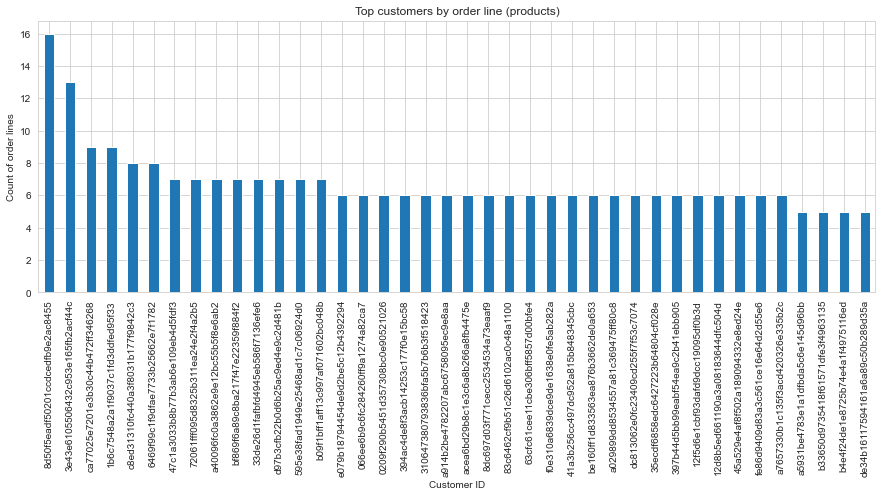

In [36]:
df_orders_consolidated.groupby('customer_unique_id')\
    .agg({'customer_id': 'count'})\
    .sort_values('customer_id', ascending=False).head(40).plot(
        kind='bar',
        figsize=(15,5),
        legend=False);
plt.title('Top customers by order line (products)')
plt.xlabel('Customer ID')
plt.ylabel('Count of order lines')

16 records means 16 order lines, not necessarily 16 orders. Let's check how many orders have the top customers placed:

### 2. Which customers placed the most orders?

Text(0, 0.5, 'Count of orders')

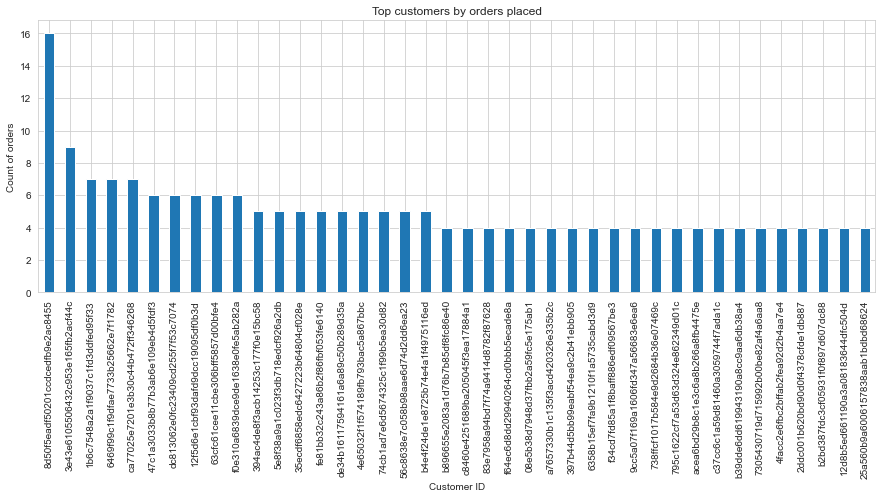

In [35]:
df_orders_consolidated\
    .groupby(['customer_unique_id', 'order_id'], as_index=False)\
    .agg({'customer_id': 'count'})\
    .groupby('customer_unique_id')\
    .agg({'order_id': 'count'})\
    .sort_values('order_id', ascending=False)\
    .head(40).plot(kind='bar', figsize=(15,5), legend=False);
plt.title('Top customers by orders placed')
plt.xlabel('Customer ID')
plt.ylabel('Count of orders')

That means that the top customer place 16 orders with each only one product but all customers after that have often more than one product in the order. The number of order lines (SKUs)in a typical ecommerce order will be very small, but I will try to see if there are some correlations between products in the same order (affinity analysis) further down.

### 2. What is the order composition in view of product category?

In [41]:
# As a refresher: Number of unique categories
df_orders_consolidated['product_category_name'].nunique()

73

In [27]:
# Creating a category- order grouped dataframe
df_order_class_comp = df_orders_consolidated.groupby([
    'order_id',
    'product_category_name'
    ], as_index=False).agg({
        'product_id': 'count',
        'qty': 'sum',
        'price': 'sum',
        'order_line_cube_in_ltr': 'sum',
        'product_weight_g': 'sum',
        'estimated_duration': 'first',
        'shipping_duration': 'first',
        'shipping_time_delta': 'first',
        'order_purchase_timestamp': 'first'
        })

In [37]:
df_order_class_comp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98019 entries, 0 to 98018
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   order_id                  98019 non-null  object 
 1   product_category_name     98019 non-null  object 
 2   product_id                98019 non-null  int64  
 3   qty                       98019 non-null  int64  
 4   price                     98019 non-null  float64
 5   order_line_cube_in_ltr    98019 non-null  float64
 6   product_weight_g          98019 non-null  float64
 7   estimated_duration        98019 non-null  int64  
 8   shipping_duration         98019 non-null  int64  
 9   shipping_time_delta       98019 non-null  int64  
 10  order_purchase_timestamp  98019 non-null  object 
dtypes: float64(3), int64(5), object(3)
memory usage: 9.0+ MB


In [38]:
df_order_class_comp.head()

,order_id,product_category_name,product_id,qty,price,order_line_cube_in_ltr,product_weight_g,estimated_duration,shipping_duration,shipping_time_delta,order_purchase_timestamp
0,00010242fe8c5a6d1ba2dd792cb16214,cool_stuff,1,1,58.90,3.528,650.0,16,7,9,2017-09-13
1,00018f77f2f0320c557190d7a144bdd3,pet_shop,1,1,239.90,60.000,30000.0,19,16,3,2017-04-26
2,000229ec398224ef6ca0657da4fc703e,moveis_decoracao,1,1,199.00,14.157,3050.0,22,8,14,2018-01-14
3,00024acbcdf0a6daa1e931b038114c75,perfumaria,1,1,12.99,2.400,200.0,12,6,6,2018-08-08
4,00042b26cf59d7ce69dfabb4e55b4fd9,ferramentas_jardim,1,1,199.90,42.000,3750.0,41,25,16,2017-02-04


Text(0.5, 0, 'Order count')

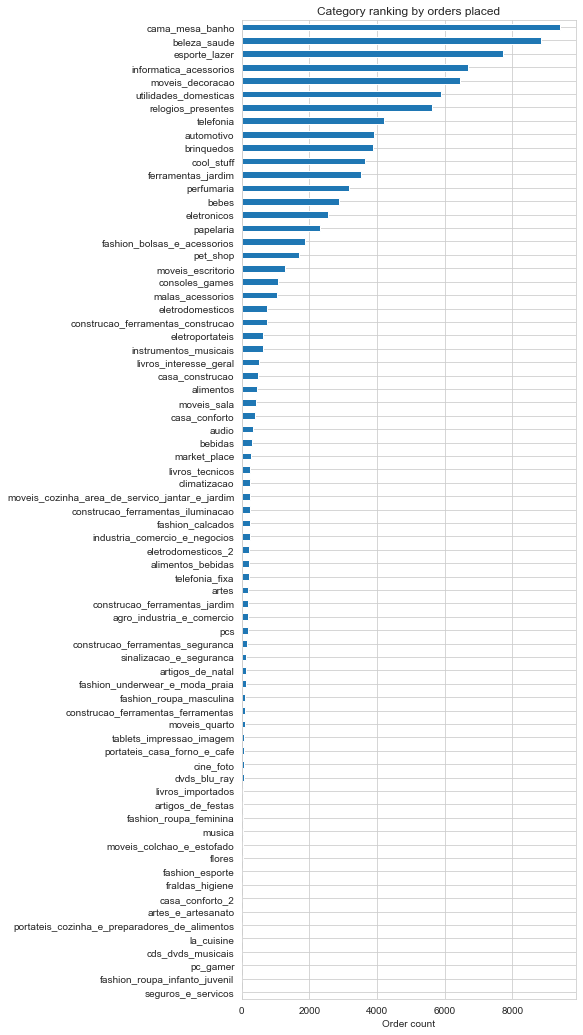

In [64]:
df_order_class_comp.groupby('product_category_name')\
    .agg({'order_id': 'count'})\
    .sort_values('order_id')\
    .plot(kind='barh', figsize=(6,18), legend=False);
plt.title('Category ranking by orders placed')
plt.ylabel('')
plt.xlabel('Order count')

---
## <a class="anchor" id="profile">III. Order and SKU profile</a>
Question to answer:

** What conclusions can we draw from the order- and SKU-profile? **

### Order profile (units per line, units per order, lines per order)

In [8]:
df_upo_lpo = df_orders_consolidated\
    .groupby('order_id')\
    .agg({
        'qty': 'sum',
        'product_id': 'count'
        })\
    .reset_index()
df_upo_lpo.rename(columns = {
    'qty': 'units',
    'product_id': 'lines'
    }, inplace = True)

In [9]:
df_upo_lpo

,order_id,units,lines
0,00010242fe8c5a6d1ba2dd792cb16214,1,1
1,00018f77f2f0320c557190d7a144bdd3,1,1
2,000229ec398224ef6ca0657da4fc703e,1,1
3,00024acbcdf0a6daa1e931b038114c75,1,1
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,1
...,...,...,...
98659,fffc94f6ce00a00581880bf54a75a037,1,1
98660,fffcd46ef2263f404302a634eb57f7eb,1,1
98661,fffce4705a9662cd70adb13d4a31832d,1,1
98662,fffe18544ffabc95dfada21779c9644f,1,1


Plotting order profile charts

In [23]:
fig, ax = plt.subplots(3, 1, figsize = (15, 20))
sns.countplot(df_upo_lpo['units'], ax = ax[0], color='black')
sns.countplot(df_upo_lpo['lines'], ax = ax[1])
sns.countplot(df_order_class_comp['qty'], ax = ax[2])
ax[0].set(
    title = 'Units per order',
    xlabel = 'units per order',
    ylabel = 'Count'
    )
ax[1].set(
    title = 'Order lines per order',
    xlabel = 'order lines per order',
    ylabel = 'Count'
    )
ax[2].set(
    title = 'Units per order line',
    xlabel = 'units per order lines',
    ylabel = 'Count'
    );

NameError: name 'df_upo_lpo' is not defined

This looks typical e-commerce: mostly SIO (single item orders); two-step-order picking is an option to deal with this (batch pick, sort, pack)

### Generating pareto diagrams
We will base them on different metrics:
- units
- lines
- volume (cube)

Step 1: Creating a SKU list with aggregated values

In [11]:
df_orders_consolidated.columns

Index(['Unnamed: 0', 'order_id', 'customer_id', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'date_ordinal', 'shipping_time_delta',
       'shipping_duration', 'estimated_duration', 'product_id', 'qty',
       'seller_id', 'shipping_limit_date', 'price', 'freight_value',
       'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'order_line_cube_in_ltr', 'price_round'],
      dtype='object')

In [12]:
df_SKUs = df_orders_consolidated\
    .groupby('product_id')\
    .agg({
        'qty': 'sum',
        'order_id': 'count',
        'order_line_cube_in_ltr': 'sum',
        'price': 'sum',
        'shipping_duration': 'mean'})

In [13]:
df_SKUs.rename(columns = {
        'qty': 'total_qty',
        'order_id': 'total_lines',
        'order_line_cube_in_ltr': 'total_cube',
        'shipping_duration': 'avg_ship_duration',
        'price': 'total_price'
        }, inplace = True)

In [14]:
# Adding counting column
df_SKUs['counter'] = 1

In [15]:
df_SKUs

,total_qty,total_lines,total_cube,total_price,avg_ship_duration,counter
product_id,,,,,,
00066f42aeeb9f3007548bb9d3f33c38,1,1,5.120,101.65,17.0,1
00088930e925c41fd95ebfe695fd2655,1,1,14.300,129.90,11.0,1
0009406fd7479715e4bef61dd91f2462,1,1,23.625,229.00,16.0,1
000b8f95fcb9e0096488278317764d19,2,2,10.944,117.80,6.5,1
000d9be29b5207b54e86aa1b1ac54872,1,1,3.630,199.00,7.0,1
...,...,...,...,...,...,...
fff6177642830a9a94a0f2cba5e476d1,2,2,31.500,229.98,9.0,1
fff81cc3158d2725c0655ab9ba0f712c,1,1,2.816,90.00,2.0,1
fff9553ac224cec9d15d49f5a263411f,1,1,2.288,32.00,10.0,1


Need to sort by quantity, then add a cummulating percent counter for unit based pareto.

In [16]:
def classifier(num):
    if num < 5:
        v_class = 'A'
    elif num < 20:
        v_class = 'B'
    elif num < 50:
        v_class = 'C'
    else:
        v_class = 'D'
    return v_class

In [17]:
def pareto_izer(dat, col):
    '''A function which adds prepares and executes a pareto curve for a given feature
    The dataframe is sorted in descending order for the given feature
    
    Inputs:     data frame, feature (column)
    
    Outputs:    column with cumulated, sorted veature values
                Pareto chart'''
    
    dat.sort_values(by = col, ascending = False, inplace = True) # sort by the feature   
    dat['cum_' + col] = dat[col].cumsum()/dat[col].sum()*100 # add or re-assign column whith the cummulated sum
    df_SKUs['v_class_' + col] = dat['cum_' + col].map(classifier) # add or re-assign SKU velocity class (ABC)

    # Plotting the chart
    f, ax = plt.subplots(figsize = (15, 7))
    ax = sns.lineplot(x = dat['counter']\
        .cumsum()/dat['counter']\
        .sum()*100, data = dat, y = ('cum_' + col))
    ax = plt.title('Pareto chart of % {} over % SKUs'. format(col))
    ax = plt.xlabel('Percentage SKUs')
    ax = plt.ylabel('Percentage {}'.format(col))
    return ax

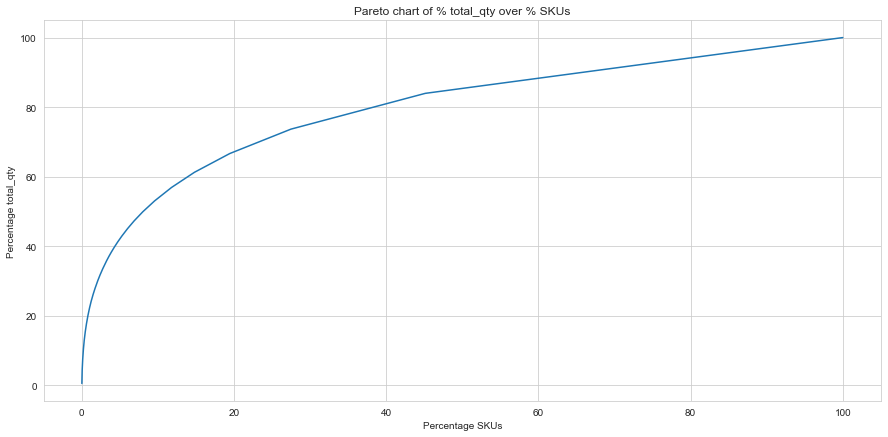

In [18]:
pareto_izer(df_SKUs, 'total_qty');

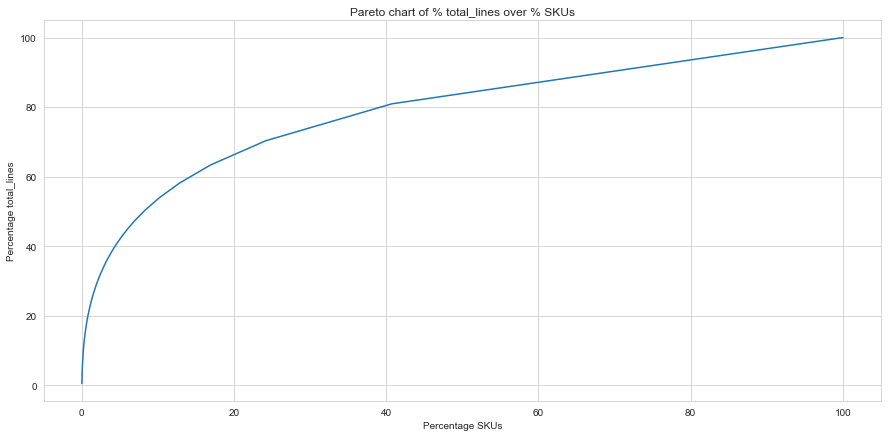

In [19]:
pareto_izer(df_SKUs, 'total_lines');

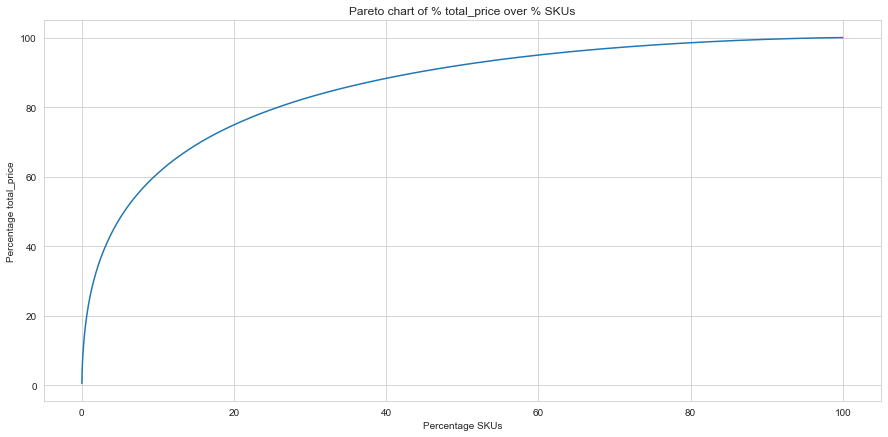

In [20]:
pareto_izer(df_SKUs, 'total_price');

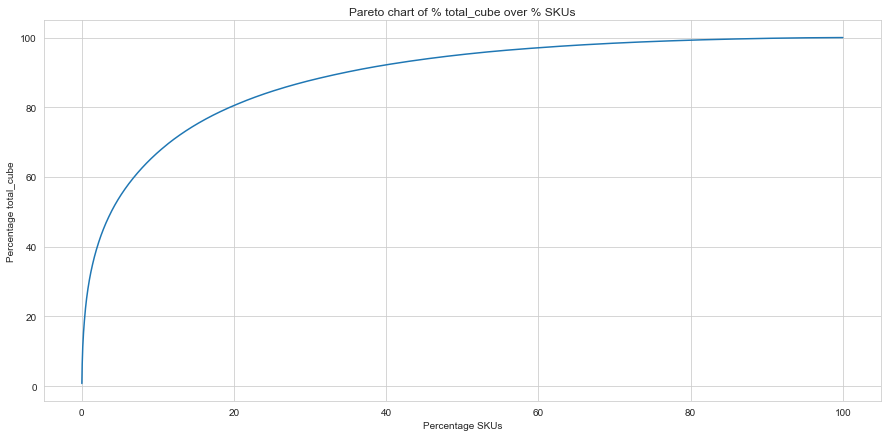

In [21]:
pareto_izer(df_SKUs, 'total_cube');

That looks like a good result. While the pareto charts of the total quantity and lines are following a 70/20 trend, the total price and total cube show a 80/20 curve.

In [22]:
df_SKUs

,total_qty,total_lines,total_cube,total_price,avg_ship_duration,counter,cum_total_qty,v_class_total_qty,cum_total_lines,v_class_total_lines,cum_total_price,v_class_total_price,cum_total_cube,v_class_total_cube
product_id,,,,,,,,,,,,,,
389d119b48cf3043d311335e499d9c6b,392,311,12763.520,16981.49,15.926045,1,1.678695,A,1.839449,A,7.317767,B,0.743309,A
99a4788cb24856965c36a24e339b6058,488,467,9760.000,41193.56,13.516060,1,0.901045,A,0.455957,A,1.951712,A,1.311702,A
422879e10f46682990de24d770e7f83d,484,352,9583.200,19265.00,15.946023,1,1.330706,A,1.220441,A,6.461199,B,1.869798,A
aca2eb7d00ea1a7b8ebd4e68314663af,527,431,7905.000,30730.60,12.044084,1,0.467833,A,0.876765,A,3.870010,A,2.330161,A
368c6c730842d78016ad823897a372db,388,291,7682.400,15776.30,15.384880,1,2.023134,A,2.422331,A,7.572857,B,2.777561,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71225f49be70df4297892f6a5fa62171,1,1,0.352,27.30,13.000000,1,98.945378,D,87.998672,D,99.578473,D,99.999932,D
2bc14ec16ec416f08e39fed48eda7f2d,1,1,0.352,34.30,14.000000,1,90.375243,D,97.066060,D,99.279255,D,99.999953,D
5a2a2db3896d33beec6828b898812ad5,1,1,0.352,27.30,5.000000,1,98.390547,D,85.897561,D,99.576116,D,99.999973,D


### Adding XYZ profile

Creating a dataframe which counts the number of active days for each SKU

In [23]:
SKUs_active_days = df_orders_consolidated\
    .groupby(['order_purchase_timestamp', 'product_id'])\
    .agg({'order_id': 'count'})\
    .reset_index()

In [24]:
SKUs_active_days = SKUs_active_days.groupby('product_id')\
    .agg({'order_purchase_timestamp': 'count'})\
    .sort_values(by='order_purchase_timestamp', ascending = False)\
    .reset_index()

In [25]:
SKUs_active_days.rename(columns = {'order_purchase_timestamp': 'active_days'}, inplace = True)

In [26]:
SKUs_active_days.head()

,product_id,active_days
0,99a4788cb24856965c36a24e339b6058,268
1,d1c427060a0f73f6b889a5c7c61f2ac4,202
2,422879e10f46682990de24d770e7f83d,196
3,2b4609f8948be18874494203496bc318,193
4,154e7e31ebfa092203795c972e5804a6,192


Adding the XYZ classification column

In [27]:
sample_timespan = df_orders_consolidated['order_purchase_timestamp'].max() - df_orders_consolidated['order_purchase_timestamp'].min()

In [28]:
def xyz_classifier(num):
    t_span = sample_timespan.days
    if num > (t_span * 2 / 3):
        activity_class = 'X'
    elif num > (t_span * 1 / 3):
        activity_class = 'Y'
    else:
        activity_class = 'Z'
        
    return activity_class

In [29]:
SKUs_active_days['XYZ_class'] = SKUs_active_days['active_days'].map(xyz_classifier)

In [30]:
SKUs_active_days

,product_id,active_days,XYZ_class
0,99a4788cb24856965c36a24e339b6058,268,Y
1,d1c427060a0f73f6b889a5c7c61f2ac4,202,Z
2,422879e10f46682990de24d770e7f83d,196,Z
3,2b4609f8948be18874494203496bc318,193,Z
4,154e7e31ebfa092203795c972e5804a6,192,Z
...,...,...,...
32944,69ac97e466e0d1329784803bb0d3319e,1,Z
32945,69abb160096c6a83656bff3c715a7497,1,Z
32946,69ab89fdb9df3f93455a0c52d6e4e3f0,1,Z
32947,69a7ee112e7b63892ad5db80e4c3277f,1,Z


Merging SKUs_active_days to df_SKUs

In [31]:
df_SKUs = df_SKUs.merge(SKUs_active_days, on = 'product_id')

In [32]:
df_SKUs.columns

Index(['product_id', 'total_qty', 'total_lines', 'total_cube', 'total_price',
       'avg_ship_duration', 'counter', 'cum_total_qty', 'v_class_total_qty',
       'cum_total_lines', 'v_class_total_lines', 'cum_total_price',
       'v_class_total_price', 'cum_total_cube', 'v_class_total_cube',
       'active_days', 'XYZ_class'],
      dtype='object')

Let's plot the XYZ diagram.

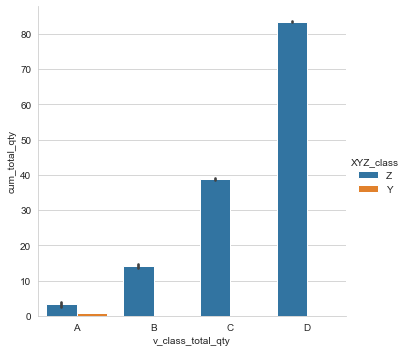

In [33]:
sns.catplot(data = df_SKUs, x = 'v_class_total_qty', y = 'cum_total_qty', kind = 'bar', aspect = 1, hue = 'XYZ_class')

In [34]:
df_SKUs['XYZ_class'].value_counts()

Z    32948
Y        1
Name: XYZ_class, dtype: int64

Almost all SKUs are Z class, which means they are sold very infrequently.

In [35]:
#sns.pairplot(df_SKUs)